In [1]:
# Import pandas, numpy, and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# seaborn is a data visualization library built on matplotlib
import seaborn as sns 

# set the plotting style 
sns.set_style("whitegrid")

# plot tree model
import graphviz

# Plot missing values
import missingno as msno

# Model preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

# Train-test splits
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV

# Models
from sklearn import linear_model, tree
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

# Model metrics and analysis
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.anova import anova_lm

# Imputation
from sklearn.impute import KNNImputer
#from fancyimpute import IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

## Clean the data

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/he-chang/data5100project/main/university_data.csv')

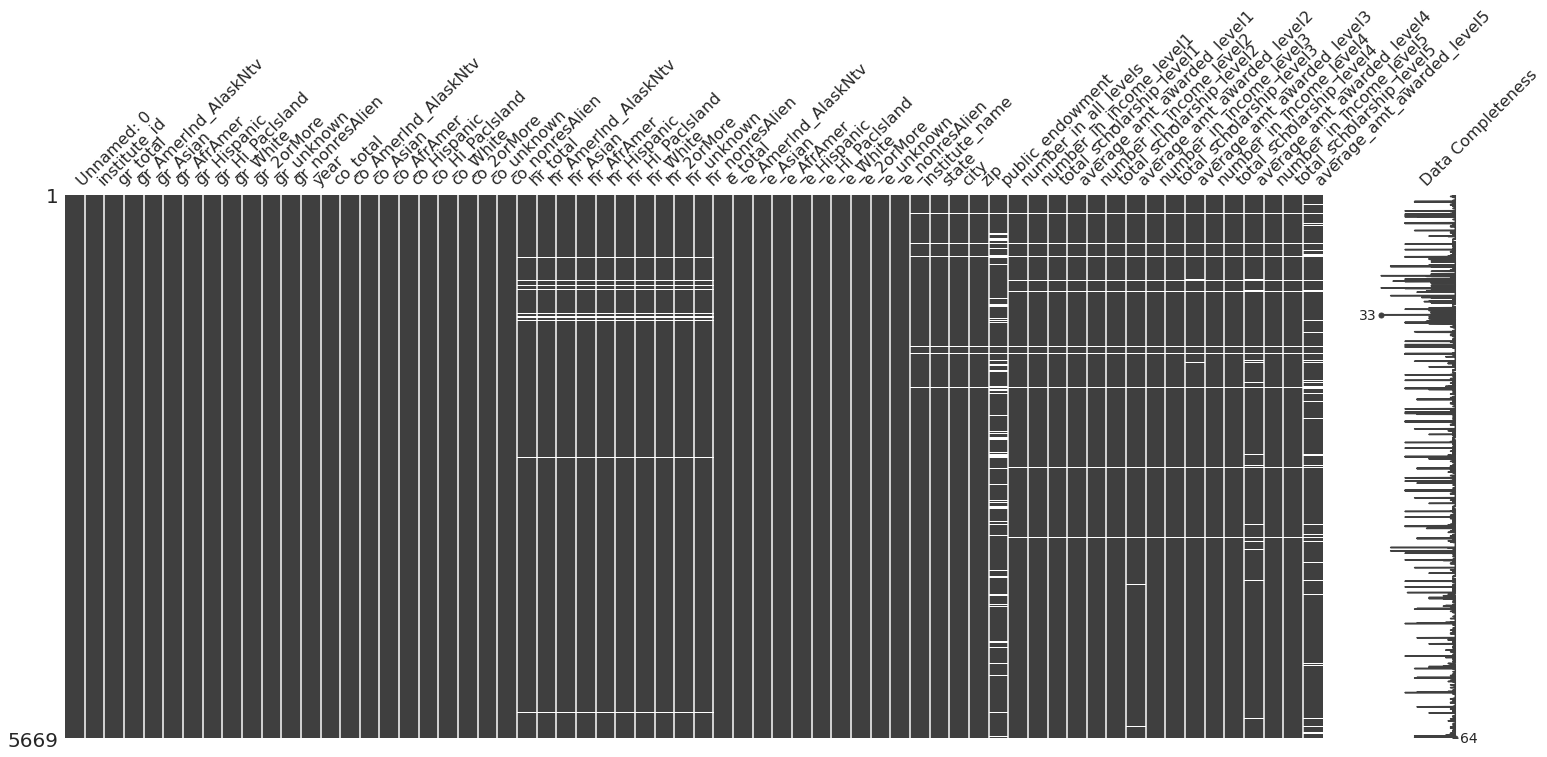

In [3]:
msno.matrix(df, labels = True);

The missing elements appeared most for hr values, endowments, and financial aid information was missing more.  Missing endowments and average amount awarded per income levels were assumed to be 0 if not reported.

In [4]:
df['public_endowment'] = df['public_endowment'].fillna(0)
df['average_amt_awarded_level2'] = df['average_amt_awarded_level2'].fillna(0)
df['average_amt_awarded_level3'] = df['average_amt_awarded_level3'].fillna(0)
df['average_amt_awarded_level4'] = df['average_amt_awarded_level4'].fillna(0)
df['average_amt_awarded_level5'] = df['average_amt_awarded_level5'].fillna(0)

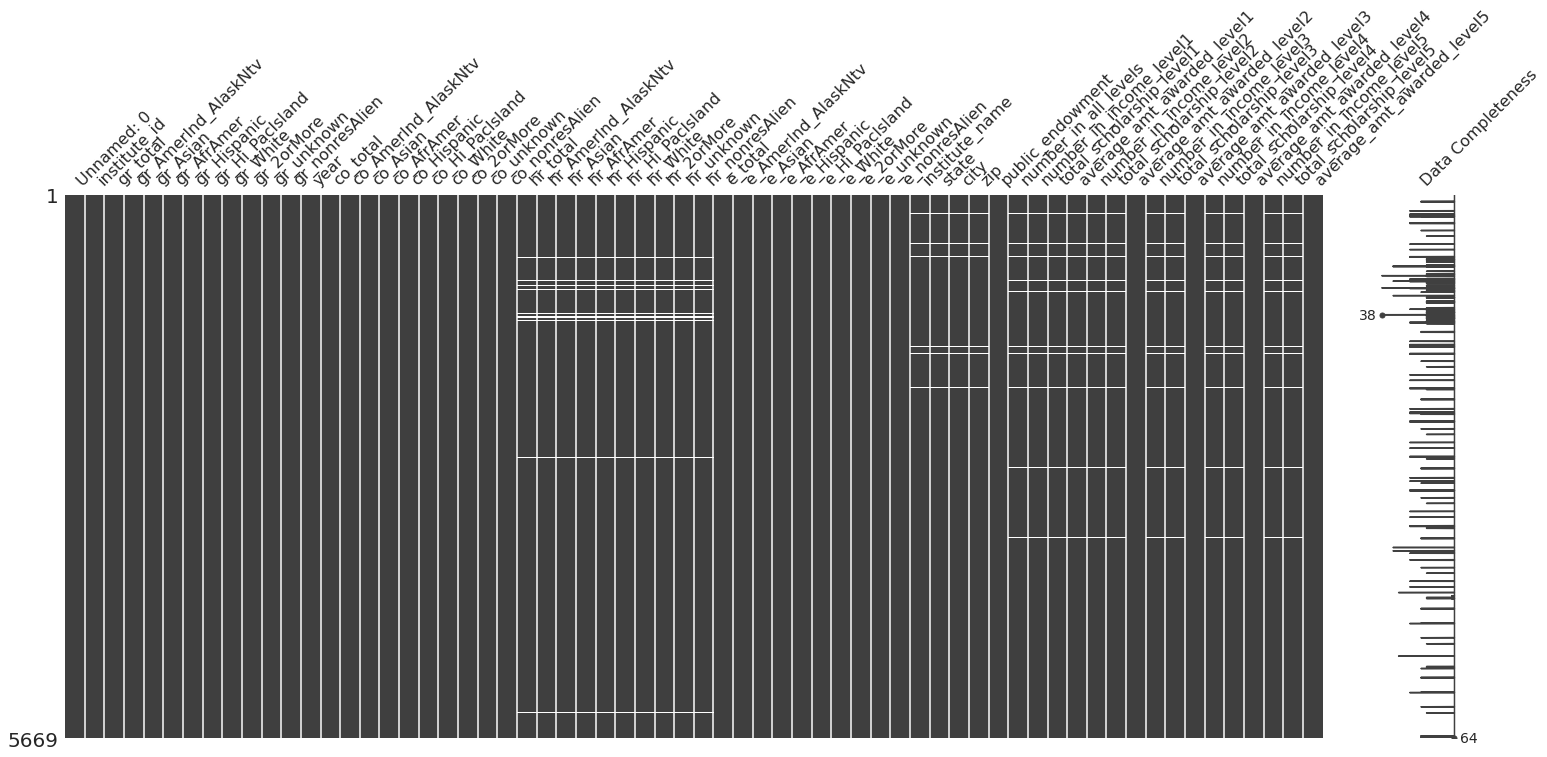

In [5]:
msno.matrix(df, labels = True);

In [6]:
# The remaning rows with missing information were dropped because they appeared random.
df = df.dropna()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5436 entries, 0 to 5668
Data columns (total 64 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  5436 non-null   int64  
 1   institute_id                5436 non-null   int64  
 2   gr_total                    5436 non-null   float64
 3   gr_AmerInd_AlaskNtv         5436 non-null   float64
 4   gr_Asian                    5436 non-null   float64
 5   gr_AfrAmer                  5436 non-null   float64
 6   gr_Hispanic                 5436 non-null   float64
 7   gr_Hi_PacIsland             5436 non-null   float64
 8   gr_White                    5436 non-null   float64
 9   gr_2orMore                  5436 non-null   float64
 10  gr_unknown                  5436 non-null   float64
 11  gr_nonresAlien              5436 non-null   float64
 12  year                        5436 non-null   int64  
 13  co_total                    5436 

## Calculate Student Income Percentages

In [8]:
# Function to calculate the percentages of students in each income level
def calcPercentage(overall_total, group_total):
  if overall_total == 0:
    return 0
  else:
    return group_total / overall_total

In [9]:
income_groups = ['number_in_income_level1', 'number_in_income_level2', 'number_in_income_level3', 'number_in_income_level4', 'number_in_income_level5']

for group in income_groups:
  new_column_name = group + "_pct"
  df[new_column_name] = df.apply(lambda x: calcPercentage(x['number_in_all_levels'], x[group]), axis = 1)

In [10]:
def calculateRange(income_lvl1, income_lvl2, income_lvl3, income_lvl4, income_lvl5):
  income_list = [income_lvl1, income_lvl2, income_lvl3, income_lvl4, income_lvl5]
  income_max = max(income_list)
  income_min = min(income_list)
  return income_max - income_min

In [11]:
def calculateMax(income_lvl1, income_lvl2, income_lvl3, income_lvl4, income_lvl5):
  income_list = [income_lvl1, income_lvl2, income_lvl3, income_lvl4, income_lvl5]
  income_max = max(income_list)

  return income_list.index(income_max) + 1

In [12]:
df['income_range'] = df.apply(lambda x: calculateRange(x['number_in_income_level1_pct'], x['number_in_income_level2_pct'], x['number_in_income_level3_pct'], x['number_in_income_level4_pct'], x['number_in_income_level5_pct']), axis = 1)
df['income_level_majority'] = df.apply(lambda x: calculateMax(x['number_in_income_level1_pct'], x['number_in_income_level2_pct'], x['number_in_income_level3_pct'], x['number_in_income_level4_pct'], x['number_in_income_level5_pct']), axis = 1)

## Calculate Percentages and difference between total graduation rate and BiPOC graduation rate

In [13]:
def getCohortGroupTotal(group_name):
  new_group_name = group_name
  return new_group_name.replace("gr", "co")

In [14]:
cohort_groups = ['co_AmerInd_AlaskNtv', 'co_AmerInd_AlaskNtv', 'co_AmerInd_AlaskNtv', 'co_Asian', 'co_AfrAmer', 'co_Hispanic', 'co_Hi_PacIsland', 'co_White', 'co_2orMore', 'co_unknown', 'co_nonresAlien']

for group in cohort_groups:
  new_column_name = group + "_pct"
  df[new_column_name] = df.apply(lambda x: calcPercentage(x['co_total'], x[group]), axis = 1)

df.head()

Unnamed: 0  institute_id  gr_total  gr_AmerInd_AlaskNtv  gr_Asian  \
0           0        100654     257.0                  0.0       0.0   
1           1        100663     741.0                  2.0      51.0   
2           2        100706     367.0                 10.0      13.0   
3           3        100724     340.0                  0.0       0.0   
4           4        100751    2958.0                 15.0      36.0   

   gr_AfrAmer  gr_Hispanic  gr_Hi_PacIsland  gr_White  gr_2orMore  ...  \
0       252.0          1.0              0.0       2.0         0.0  ...   
1       181.0         17.0              0.0     441.0        19.0  ...   
2        50.0          6.0              0.0     264.0         7.0  ...   
3       332.0          1.0              0.0       1.0         2.0  ...   
4       214.0         55.0              0.0    2623.0         0.0  ...   

   income_level_majority  co_AmerInd_AlaskNtv_pct  co_Asian_pct  \
0                      1                 0.001134      0.000000   
1                      1                 0.002177      0.054427   
2                      1                 0.019763      0.026350   
3                      1                 0.000000      0.000000   
4                      1                 0.004507      0.011492   

   co_AfrAmer_pct  co_Hispanic_pct  co_Hi_PacIsland_pct  co_White_pct  \
0        0.977324         0.005669                  0.0      0.010204   
1        0.253266         0.019594                  0.0      0.605951   
2        0.139657         0.022398                  0.0      0.747036   
3        0.974093         0.002961                  0.0      0.008882   
4        0.085174         0.017125                  0.0      0.876521   

   co_2orMore_pct  co_unknown_pct  co_nonresAlien_pct  
0        0.000000        0.000000            0.005669  
1        0.021771        0.026125            0.016691  
2        0.014493        0.003953            0.026350  
3        0.001480        0.009623            0.002961  
4        0.000000        0.000000            0.005183  

[5 rows x 80 columns]

In [15]:
grad_groups = ['gr_total', 'gr_AmerInd_AlaskNtv', 'gr_Asian', 'gr_AfrAmer', 'gr_Hispanic', 'gr_Hi_PacIsland', 'gr_White', 'gr_2orMore', 'gr_unknown', 'gr_nonresAlien']

for group in grad_groups:
  new_column_name = group + "_pct"
  total_group = getCohortGroupTotal(group)
  df[new_column_name] = df.apply(lambda x: calcPercentage(x[total_group], x[group]), axis = 1)

df.head()

Unnamed: 0  institute_id  gr_total  gr_AmerInd_AlaskNtv  gr_Asian  \
0           0        100654     257.0                  0.0       0.0   
1           1        100663     741.0                  2.0      51.0   
2           2        100706     367.0                 10.0      13.0   
3           3        100724     340.0                  0.0       0.0   
4           4        100751    2958.0                 15.0      36.0   

   gr_AfrAmer  gr_Hispanic  gr_Hi_PacIsland  gr_White  gr_2orMore  ...  \
0       252.0          1.0              0.0       2.0         0.0  ...   
1       181.0         17.0              0.0     441.0        19.0  ...   
2        50.0          6.0              0.0     264.0         7.0  ...   
3       332.0          1.0              0.0       1.0         2.0  ...   
4       214.0         55.0              0.0    2623.0         0.0  ...   

   gr_total_pct  gr_AmerInd_AlaskNtv_pct  gr_Asian_pct  gr_AfrAmer_pct  \
0      0.291383                 0.000000      0.000000        0.292343   
1      0.537736                 0.666667      0.680000        0.518625   
2      0.483531                 0.666667      0.650000        0.471698   
3      0.251665                 0.000000      0.000000        0.252280   
4      0.666516                 0.750000      0.705882        0.566138   

   gr_Hispanic_pct  gr_Hi_PacIsland_pct  gr_White_pct  gr_2orMore_pct  \
0         0.200000                  0.0      0.222222        0.000000   
1         0.629630                  0.0      0.528144        0.633333   
2         0.352941                  0.0      0.465608        0.636364   
3         0.250000                  0.0      0.083333        1.000000   
4         0.723684                  0.0      0.674293        0.000000   

   gr_unknown_pct  gr_nonresAlien_pct  
0        0.000000            0.400000  
1        0.416667            0.652174  
2        0.666667            0.750000  
3        0.307692            0.000000  
4        0.000000            0.652174  

[5 rows x 90 columns]

In [16]:
enr_groups = ['e_AmerInd_AlaskNtv', 'e_Asian', 'e_AfrAmer', 'e_Hispanic', 'e_Hi_PacIsland', 'e_White', 'e_2orMore', 'e_unknown', 'e_nonresAlien']

for group in enr_groups:
  new_column_name = group + "_pct"
  df[new_column_name] = df.apply(lambda x: calcPercentage(x['e_total'], x[group]), axis = 1)
  
df.head()

Unnamed: 0  institute_id  gr_total  gr_AmerInd_AlaskNtv  gr_Asian  \
0           0        100654     257.0                  0.0       0.0   
1           1        100663     741.0                  2.0      51.0   
2           2        100706     367.0                 10.0      13.0   
3           3        100724     340.0                  0.0       0.0   
4           4        100751    2958.0                 15.0      36.0   

   gr_AfrAmer  gr_Hispanic  gr_Hi_PacIsland  gr_White  gr_2orMore  ...  \
0       252.0          1.0              0.0       2.0         0.0  ...   
1       181.0         17.0              0.0     441.0        19.0  ...   
2        50.0          6.0              0.0     264.0         7.0  ...   
3       332.0          1.0              0.0       1.0         2.0  ...   
4       214.0         55.0              0.0    2623.0         0.0  ...   

   gr_nonresAlien_pct  e_AmerInd_AlaskNtv_pct  e_Asian_pct  e_AfrAmer_pct  \
0            0.400000                0.001594     0.006375       0.922311   
1            0.652174                0.002585     0.048470       0.211601   
2            0.750000                0.012744     0.037419       0.117001   
3            0.000000                0.001481     0.002305       0.910288   
4            0.652174                0.004374     0.011683       0.114612   

   e_Hispanic_pct  e_Hi_PacIsland_pct  e_White_pct  e_2orMore_pct  \
0        0.009761            0.000797     0.050996       0.000000   
1        0.026282            0.000754     0.638356       0.028221   
2        0.030369            0.000136     0.693736       0.014507   
3        0.011687            0.000658     0.033909       0.006255   
4        0.029955            0.001065     0.769970       0.019913   

   e_unknown_pct  e_nonresAlien_pct  
0       0.007968           0.000199  
1       0.012764           0.030967  
2       0.033080           0.061009  
3       0.013663           0.019753  
4       0.004086           0.044343  

[5 rows x 99 columns]

In [17]:
hr_groups = ['hr_AmerInd_AlaskNtv', 'hr_Asian', 'hr_AfrAmer', 'hr_Hispanic', 'hr_Hi_PacIsland', 'hr_White', 'hr_2orMore', 'hr_unknown']

for group in hr_groups:
  new_column_name = group + "_pct"
  df[new_column_name] = df.apply(lambda x: calcPercentage(x['hr_total'], x[group]), axis = 1)

df.head()

Unnamed: 0  institute_id  gr_total  gr_AmerInd_AlaskNtv  gr_Asian  \
0           0        100654     257.0                  0.0       0.0   
1           1        100663     741.0                  2.0      51.0   
2           2        100706     367.0                 10.0      13.0   
3           3        100724     340.0                  0.0       0.0   
4           4        100751    2958.0                 15.0      36.0   

   gr_AfrAmer  gr_Hispanic  gr_Hi_PacIsland  gr_White  gr_2orMore  ...  \
0       252.0          1.0              0.0       2.0         0.0  ...   
1       181.0         17.0              0.0     441.0        19.0  ...   
2        50.0          6.0              0.0     264.0         7.0  ...   
3       332.0          1.0              0.0       1.0         2.0  ...   
4       214.0         55.0              0.0    2623.0         0.0  ...   

   e_unknown_pct  e_nonresAlien_pct  hr_AmerInd_AlaskNtv_pct  hr_Asian_pct  \
0       0.007968           0.000199                 0.002950      0.058997   
1       0.012764           0.030967                 0.001647      0.134623   
2       0.033080           0.061009                 0.002101      0.100840   
3       0.013663           0.019753                 0.004890      0.066015   
4       0.004086           0.044343                 0.000555      0.063298   

   hr_AfrAmer_pct  hr_Hispanic_pct  hr_Hi_PacIsland_pct  hr_White_pct  \
0        0.761062         0.002950             0.002950      0.123894   
1        0.058872         0.028818             0.000000      0.748868   
2        0.046218         0.016807             0.000000      0.794118   
3        0.606357         0.012225             0.002445      0.229829   
4        0.063298         0.018323             0.000555      0.826763   

   hr_2orMore_pct  hr_unknown_pct  
0        0.000000        0.011799  
1        0.002470        0.000000  
2        0.000000        0.014706  
3        0.000000        0.078240  
4        0.002221        0.000000  

[5 rows x 107 columns]

In [18]:
# Staff BiPOC percentage = all non-white race and ethnicities staff counts added together / total staff

df['hr_BiPOC_pct'] = ((df['hr_AmerInd_AlaskNtv'] + df['hr_Asian'] + df['hr_AfrAmer'] + df['hr_Hispanic'] + df['hr_Hi_PacIsland'] + df['hr_2orMore'])/df['hr_total'])

In [19]:
# Cohort BiPOC Percentage = all non-white race and ethnicities cohort counts added together / total cohort size

df['co_BiPOC_pct'] = ((df['co_AmerInd_AlaskNtv'] + df['co_Asian'] + df['co_AfrAmer'] + df['co_Hispanic'] + df['co_Hi_PacIsland'] + df['co_2orMore'])/df['co_total'])

In [20]:
# BiPOC Graduation Percentage = all non-white race and ethnicities graduation counts added together / all non-white race and ethnicity group cohort counts added together

df['gr_BiPOC_pct'] = ((df['gr_AmerInd_AlaskNtv'] + df['gr_Asian'] + df['gr_AfrAmer'] + df['gr_Hispanic'] + df['gr_Hi_PacIsland'] + df['gr_2orMore'])/
                      ((df['co_AmerInd_AlaskNtv'] + df['co_Asian'] + df['co_AfrAmer'] + df['co_Hispanic'] + df['co_Hi_PacIsland'] + df['co_2orMore'])))

In [21]:
# BiPOC Enrollment Percentage = all non-white race and ethnicities enrollment counts added together / total enrollment count

df['e_BiPOC_pct'] = ((df['e_AmerInd_AlaskNtv'] + df['e_Asian'] + df['e_AfrAmer'] + df['e_Hispanic'] + df['e_Hi_PacIsland'] + df['e_2orMore'])/df['e_total'])

In [22]:
# Calculate the difference between the total graduation rate and BiPOC graduation rate for each school
df['gr_BiPOC_diff_pct'] = (df['gr_total_pct'] - df['gr_BiPOC_pct'])
df['gr_BiPOC_White_diff_pct'] = (df['gr_White_pct'] - df['gr_BiPOC_pct'])

## Set Graphing Functions

In [23]:
def graphPlots(colx, coly, labelx, labely):
  # Set figure size
  plt.figure(figsize = (14, 8))

  # Setup scatter plot for 
  sns.scatterplot(data = df, x = colx, y = coly, color = 'blue', alpha = 0.4)

  # Label x and y axis
  plt.xlabel(labelx, fontsize = 18)
  plt.ylabel(labely, fontsize = 18)

  plt.ticklabel_format(style='plain')
  #plt.xlim(0.0, 1.0)
  #plt.ylim(0.0, 1.0)

  plt.tick_params(labelsize = 15);

In [24]:
def graphPlotsPerYear(colx, coly, labelx, labely, year):
  # Set figure size
  plt.figure(figsize = (14, 8))

  # Setup scatter plot for 
  sns.scatterplot(data = df[df['year'] == year], x = colx, y = coly)

  # Label x and y axis
  plt.xlabel(labelx, fontsize = 18)
  plt.ylabel(labely, fontsize = 18)

  #plt.xlim(0.0, 1.0)
  #plt.ylim(0.0, 1.0)

  plt.tick_params(labelsize = 15);

In [25]:
df.groupby('year')[['year', 'gr_BiPOC_pct']].mean()

year  gr_BiPOC_pct
year                      
2013  2013.0      0.388427
2014  2014.0      0.404400
2015  2015.0      0.395135
2016  2016.0      0.388521
2017  2017.0      0.391309
2018  2018.0      0.409493
2019  2019.0      0.415631
2020  2020.0      0.419593

In [26]:
df.groupby('year')[['year', 'co_BiPOC_pct']].mean()

year  co_BiPOC_pct
year                      
2013  2013.0      0.322621
2014  2014.0      0.318437
2015  2015.0      0.337228
2016  2016.0      0.363116
2017  2017.0      0.381453
2018  2018.0      0.388387
2019  2019.0      0.400319
2020  2020.0      0.411369

In [27]:
df.groupby('year')[['year', 'gr_total_pct']].mean()

year  gr_total_pct
year                      
2013  2013.0      0.452162
2014  2014.0      0.464912
2015  2015.0      0.454980
2016  2016.0      0.451073
2017  2017.0      0.453576
2018  2018.0      0.467598
2019  2019.0      0.469816
2020  2020.0      0.474256

In [28]:
df.groupby('year')[['year', 'gr_BiPOC_White_diff_pct']].mean()

year  gr_BiPOC_White_diff_pct
year                                 
2013  2013.0                 0.073585
2014  2014.0                 0.075468
2015  2015.0                 0.068413
2016  2016.0                 0.075314
2017  2017.0                 0.078300
2018  2018.0                 0.070705
2019  2019.0                 0.067317
2020  2020.0                 0.067985

In [29]:
df.head()

Unnamed: 0  institute_id  gr_total  gr_AmerInd_AlaskNtv  gr_Asian  \
0           0        100654     257.0                  0.0       0.0   
1           1        100663     741.0                  2.0      51.0   
2           2        100706     367.0                 10.0      13.0   
3           3        100724     340.0                  0.0       0.0   
4           4        100751    2958.0                 15.0      36.0   

   gr_AfrAmer  gr_Hispanic  gr_Hi_PacIsland  gr_White  gr_2orMore  ...  \
0       252.0          1.0              0.0       2.0         0.0  ...   
1       181.0         17.0              0.0     441.0        19.0  ...   
2        50.0          6.0              0.0     264.0         7.0  ...   
3       332.0          1.0              0.0       1.0         2.0  ...   
4       214.0         55.0              0.0    2623.0         0.0  ...   

   hr_Hi_PacIsland_pct  hr_White_pct  hr_2orMore_pct  hr_unknown_pct  \
0             0.002950      0.123894        0.000000        0.011799   
1             0.000000      0.748868        0.002470        0.000000   
2             0.000000      0.794118        0.000000        0.014706   
3             0.002445      0.229829        0.000000        0.078240   
4             0.000555      0.826763        0.002221        0.000000   

   hr_BiPOC_pct  co_BiPOC_pct  gr_BiPOC_pct  e_BiPOC_pct  gr_BiPOC_diff_pct  \
0      0.828909      0.984127      0.291475     0.940837          -0.000091   
1      0.226431      0.351234      0.557851     0.317913          -0.020115   
2      0.165966      0.222661      0.508876     0.212175          -0.025345   
3      0.691932      0.978534      0.253404     0.932675          -0.001739   
4      0.148251      0.118297      0.609524     0.181601           0.056993   

   gr_BiPOC_White_diff_pct  
0                -0.069252  
1                -0.029708  
2                -0.043267  
3                -0.170071  
4                 0.064769  

[5 rows x 113 columns]

## Visualizations and Exploratory Analysis

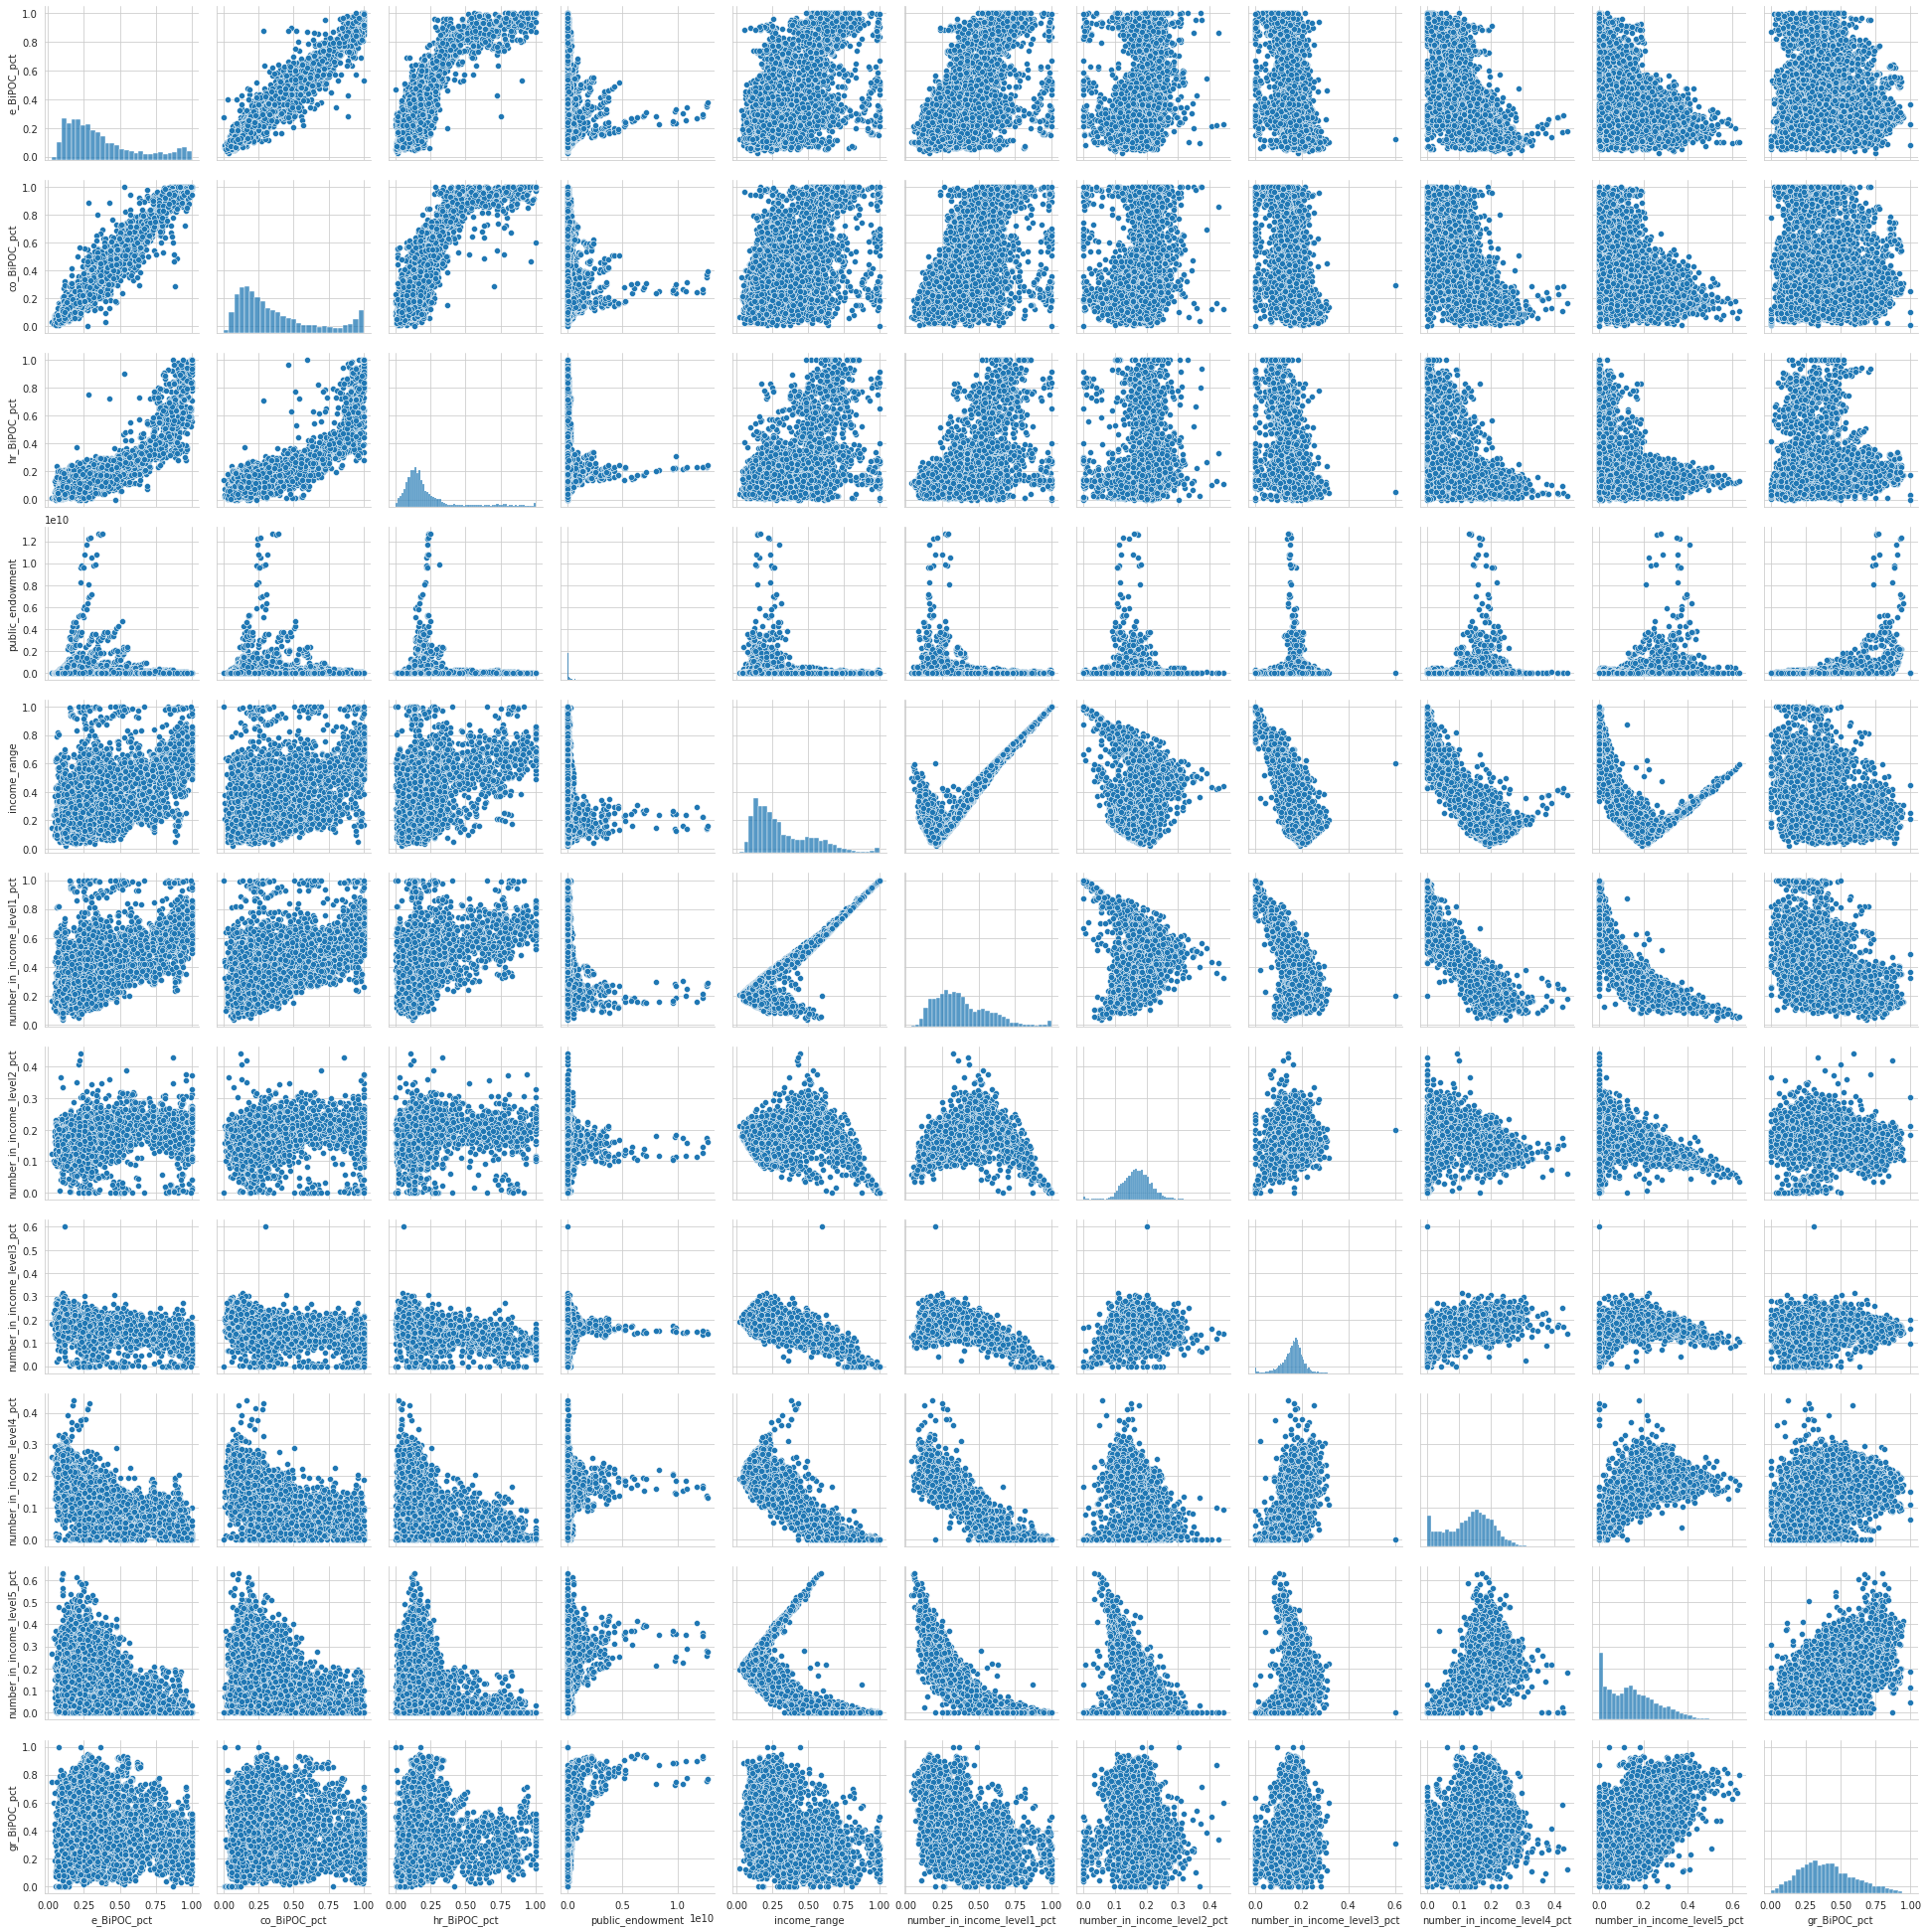

In [30]:
sns.pairplot(df[['e_BiPOC_pct', 'co_BiPOC_pct', 'hr_BiPOC_pct', 'public_endowment', 'income_range', 
                 'number_in_income_level1_pct', 'number_in_income_level2_pct', 'number_in_income_level3_pct', 'number_in_income_level4_pct', 'number_in_income_level5_pct', 'gr_BiPOC_pct']])

In [31]:
# Check the BiPOC grad percentage statistics
df['gr_BiPOC_pct'].describe()

count    5435.000000
mean        0.401739
std         0.193778
min         0.000000
25%         0.258672
50%         0.382834
75%         0.526325
max         1.000000
Name: gr_BiPOC_pct, dtype: float64

In [32]:
# Check the total grad percentage statistics
df['gr_total_pct'].describe()

count    5436.000000
mean        0.461140
std         0.185243
min         0.020492
25%         0.325055
50%         0.451827
75%         0.583208
max         1.000000
Name: gr_total_pct, dtype: float64

In [33]:
# Check endwoment statistics
df['public_endowment'].describe()

count    5.436000e+03
mean     1.917488e+08
std      7.632746e+08
min      0.000000e+00
25%      6.299746e+06
50%      2.447242e+07
75%      8.252493e+07
max      1.272053e+10
Name: public_endowment, dtype: float64

In [34]:
# Check endwoment statistics
df['number_in_income_level5_pct'].describe()

count    5436.000000
mean        0.151247
std         0.115102
min         0.000000
25%         0.052555
50%         0.137602
75%         0.224658
max         0.629496
Name: number_in_income_level5_pct, dtype: float64

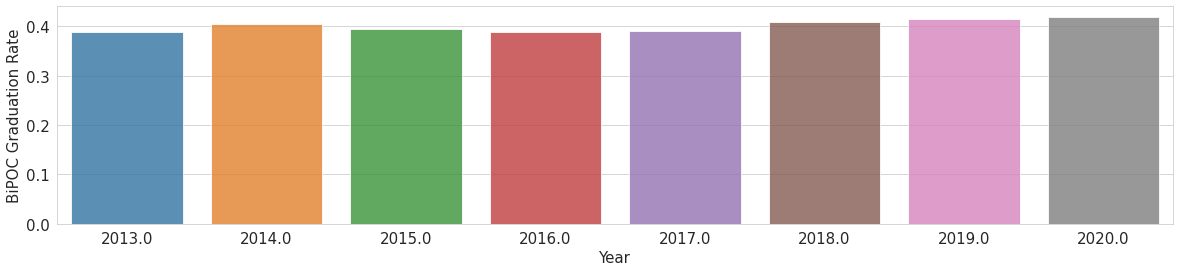

In [35]:
plt.figure(figsize = (20, 4))
df_barplot = df.groupby('year')[['year', 'gr_BiPOC_pct']].mean()
sns.barplot(data = df_barplot, x = 'year', y = 'gr_BiPOC_pct', alpha = 0.8)

plt.xlabel('Year', fontsize = 15)
plt.ylabel("BiPOC Graduation Rate", fontsize = 15)
plt.tick_params(labelsize = 15);

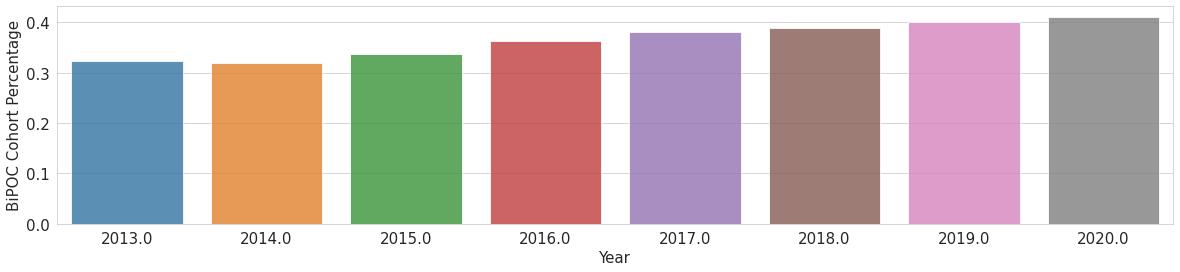

In [36]:
plt.figure(figsize = (20, 4))
df_barplot = df.groupby('year')[['year', 'co_BiPOC_pct']].mean()
sns.barplot(data = df_barplot, x = 'year', y = 'co_BiPOC_pct', alpha = 0.8)

plt.xlabel('Year', fontsize = 15)
plt.ylabel("BiPOC Cohort Percentage", fontsize = 15)
plt.tick_params(labelsize = 15);

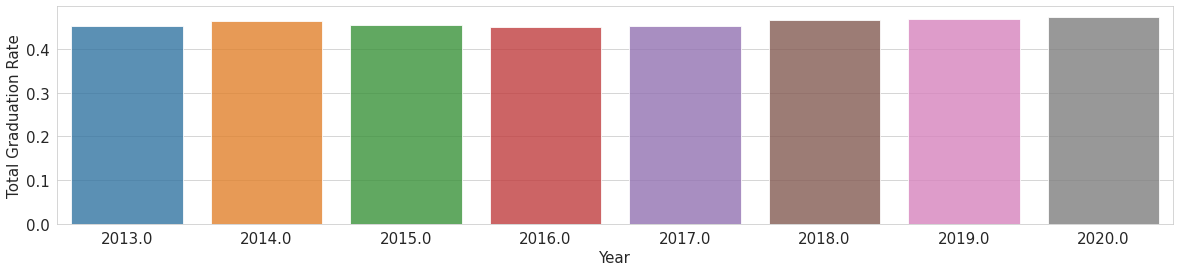

In [37]:
plt.figure(figsize = (20, 4))
df_barplot = df.groupby('year')[['year', 'gr_total_pct']].mean()
sns.barplot(data = df_barplot, x = 'year', y = 'gr_total_pct', alpha = 0.8)

plt.xlabel('Year', fontsize = 15)
plt.ylabel("Total Graduation Rate", fontsize = 15)
plt.tick_params(labelsize = 15);

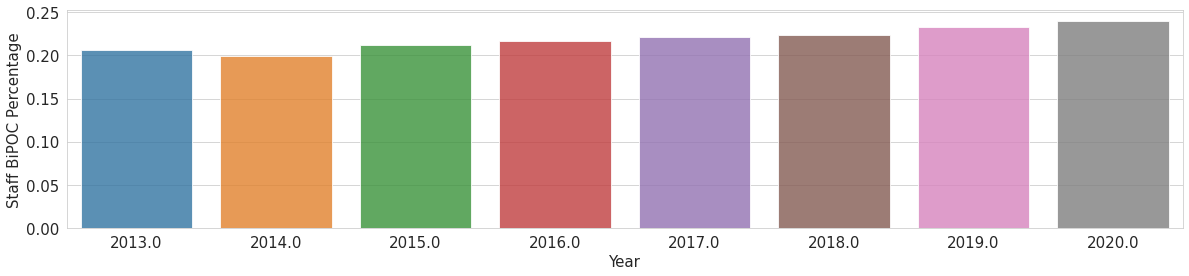

In [38]:
plt.figure(figsize = (20, 4))
df_barplot = df.groupby('year')[['year', 'hr_BiPOC_pct']].mean()
sns.barplot(data = df_barplot, x = 'year', y = 'hr_BiPOC_pct', alpha = 0.8)

plt.xlabel('Year', fontsize = 15)
plt.ylabel("Staff BiPOC Percentage", fontsize = 15)
plt.tick_params(labelsize = 15);

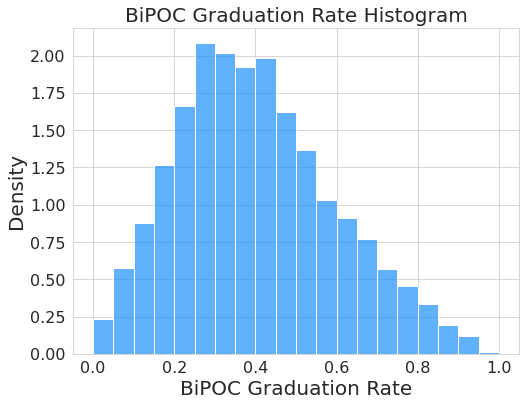

In [39]:
plt.figure(figsize = (8,6))

# Setup histogram plot
sns.histplot(data = df, x = 'gr_BiPOC_pct', bins = 20, color = 'dodgerblue', alpha = 0.7, stat = 'density')

# Label x and y axis
plt.xlabel('BiPOC Graduation Rate', fontsize = 20)
plt.ylabel('Density', fontsize = 20)

plt.title('BiPOC Graduation Rate Histogram', fontsize = 20)
plt.tick_params(labelsize = 16)

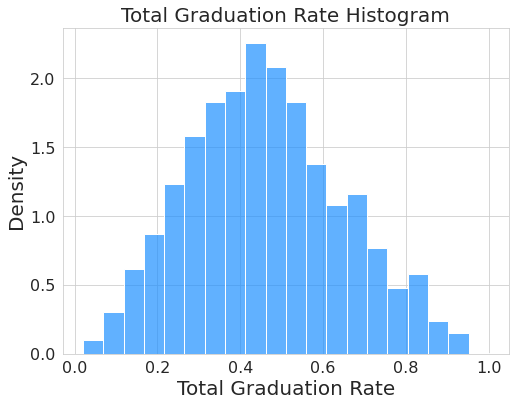

In [40]:
plt.figure(figsize = (8,6))

# Setup histogram plot
sns.histplot(data = df, x = 'gr_total_pct', bins = 20, color = 'dodgerblue', alpha = 0.7, stat = 'density')

# Label x and y axis
plt.xlabel('Total Graduation Rate', fontsize = 20)
plt.ylabel('Density', fontsize = 20)

plt.title('Total Graduation Rate Histogram', fontsize = 20)
plt.tick_params(labelsize = 16)

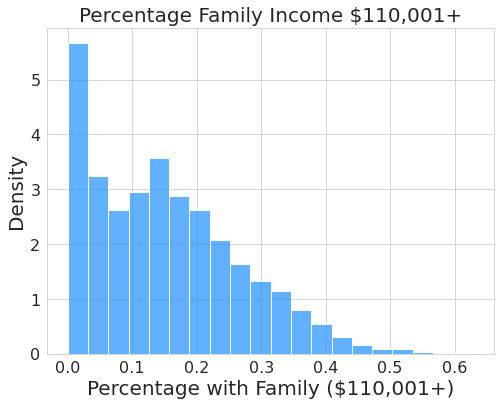

In [41]:
plt.figure(figsize = (8,6))

# Setup histogram plot
sns.histplot(data = df, x = 'number_in_income_level5_pct', bins = 20, color = 'dodgerblue', alpha = 0.7, stat = 'density')

# Label x and y axis
plt.xlabel('Percentage with Family ($110,001+)', fontsize = 20)
plt.ylabel('Density', fontsize = 20)

plt.title('Percentage Family Income $110,001+', fontsize = 20)
plt.tick_params(labelsize = 16)

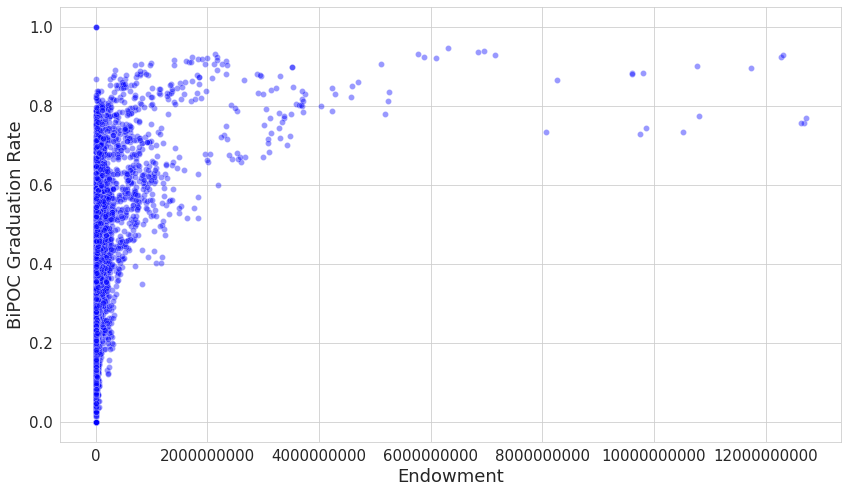

In [42]:
graphPlots('public_endowment', 'gr_BiPOC_pct', "Endowment", "BiPOC Graduation Rate")

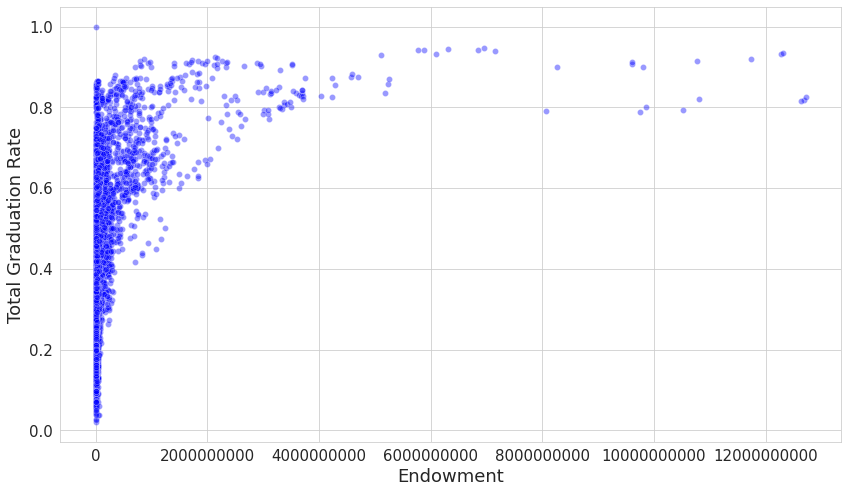

In [43]:
graphPlots('public_endowment', 'gr_total_pct', "Endowment", "Total Graduation Rate")

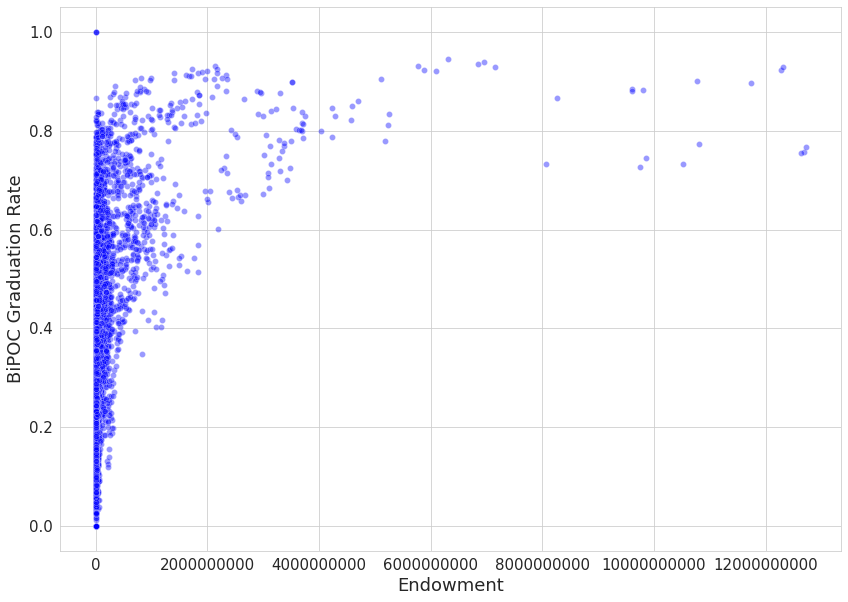

In [44]:
# Set figure size
plt.figure(figsize = (14, 10))

# Setup scatter plot for 
sns.scatterplot(data = df, x = 'public_endowment', y = 'gr_BiPOC_pct', color = 'blue', alpha = 0.4)

# Label x and y axis
plt.xlabel('Endowment', fontsize = 18)
plt.ylabel('BiPOC Graduation Rate', fontsize = 18)

plt.ticklabel_format(style='plain')
#plt.xlim(0.0, 1.0)
#plt.ylim(0.0, 1.0)

plt.tick_params(labelsize = 15);

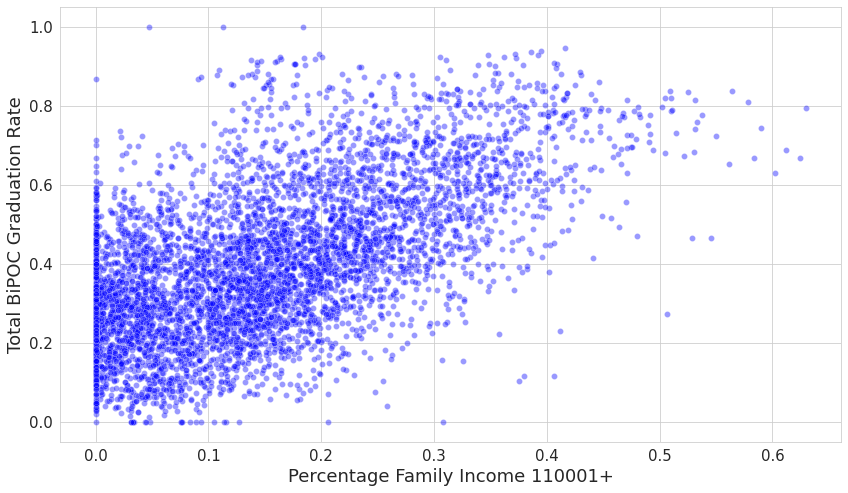

In [45]:
graphPlots('number_in_income_level5_pct', 'gr_BiPOC_pct', "Percentage Family Income 110001+", "Total BiPOC Graduation Rate")

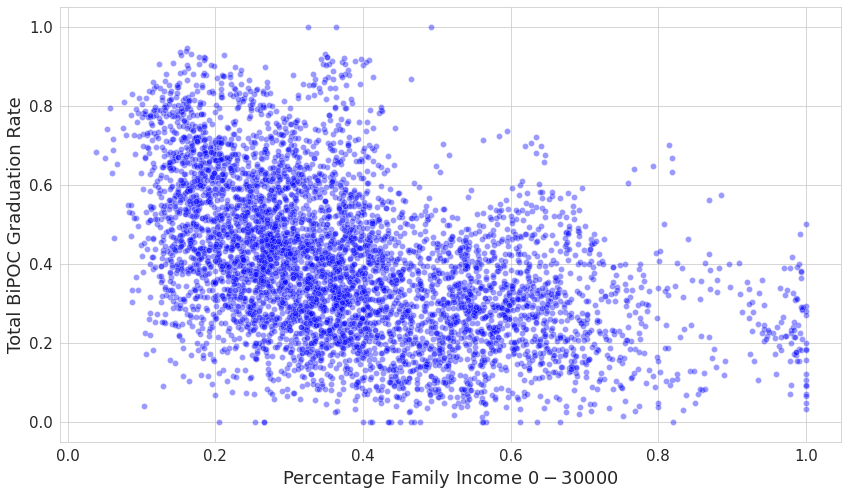

In [46]:
graphPlots('number_in_income_level1_pct', 'gr_BiPOC_pct', "Percentage Family Income $0 - $30000", "Total BiPOC Graduation Rate")

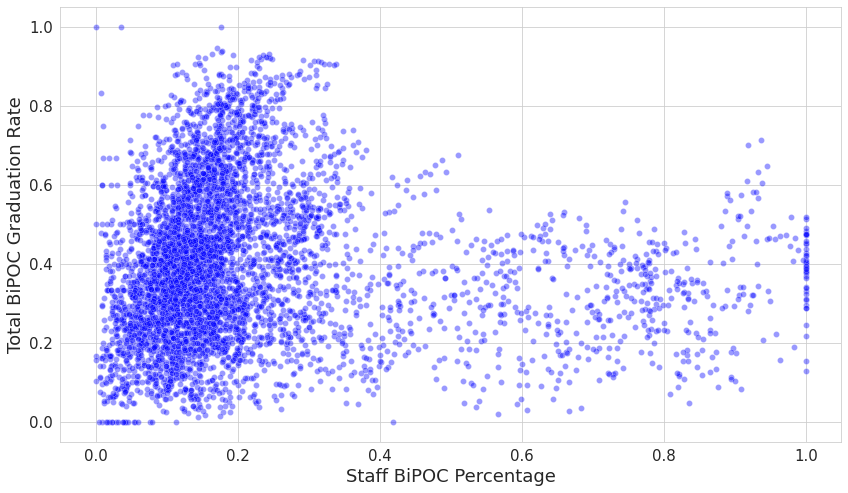

In [47]:
graphPlots('hr_BiPOC_pct', 'gr_BiPOC_pct', "Staff BiPOC Percentage", "Total BiPOC Graduation Rate")

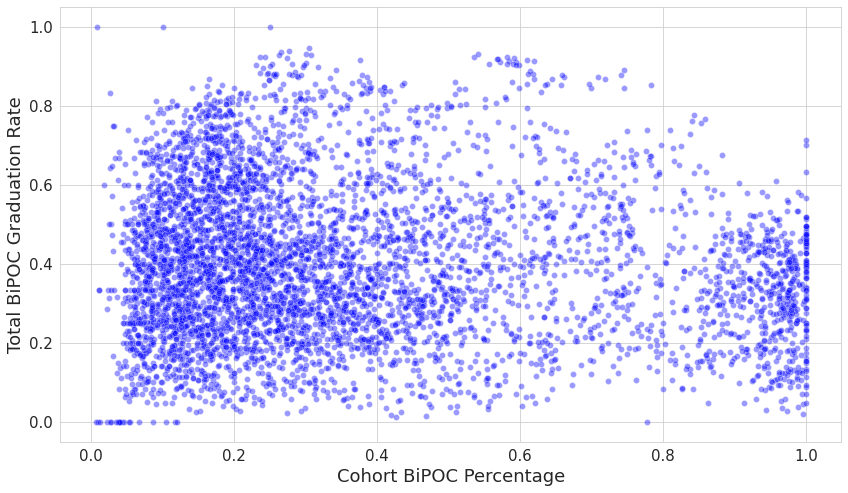

In [48]:
graphPlots('co_BiPOC_pct', 'gr_BiPOC_pct', "Cohort BiPOC Percentage", "Total BiPOC Graduation Rate")

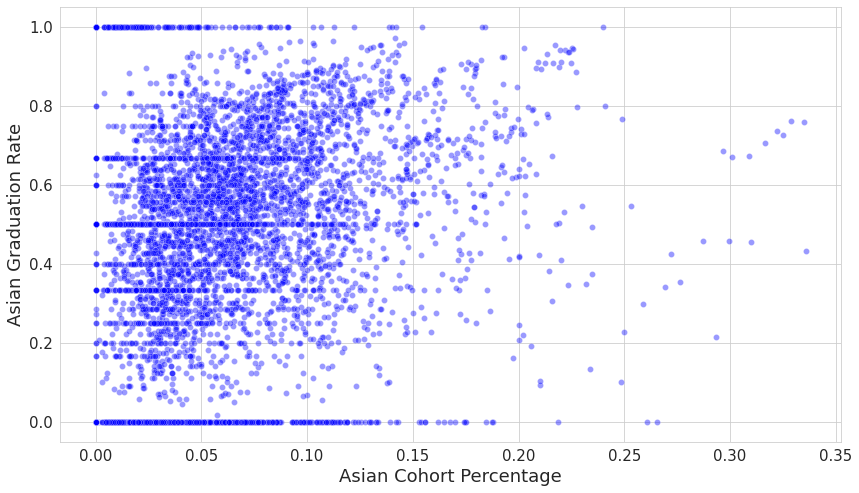

In [49]:
graphPlots('hr_Asian_pct', 'gr_Asian_pct', "Asian Cohort Percentage", "Asian Graduation Rate")

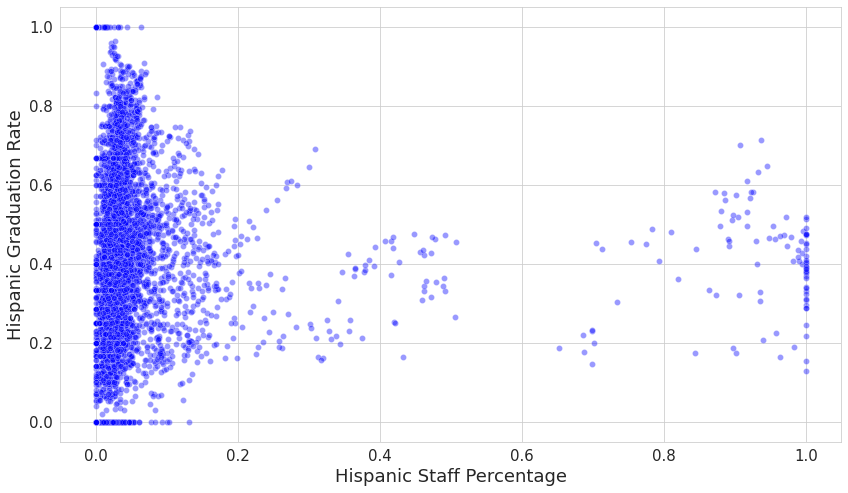

In [50]:
graphPlots('hr_Hispanic_pct', 'gr_Hispanic_pct', "Hispanic Staff Percentage", "Hispanic Graduation Rate")

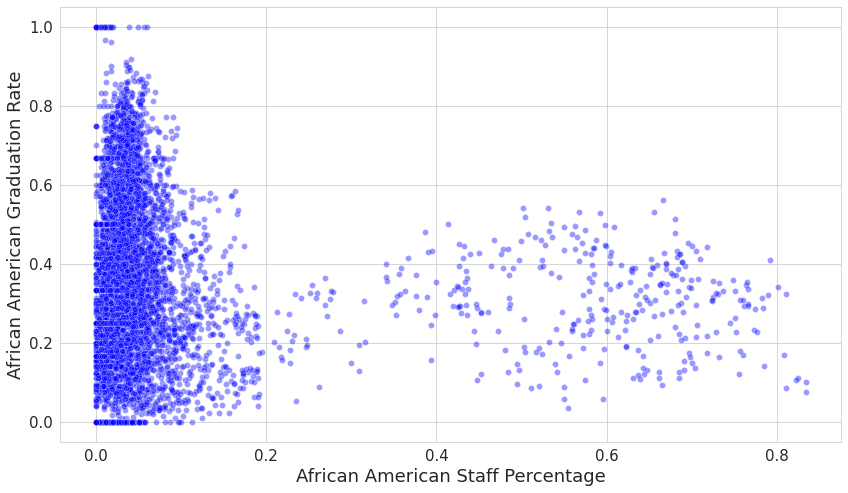

In [51]:
graphPlots('hr_AfrAmer_pct', 'gr_AfrAmer_pct', "African American Staff Percentage", "African American Graduation Rate")

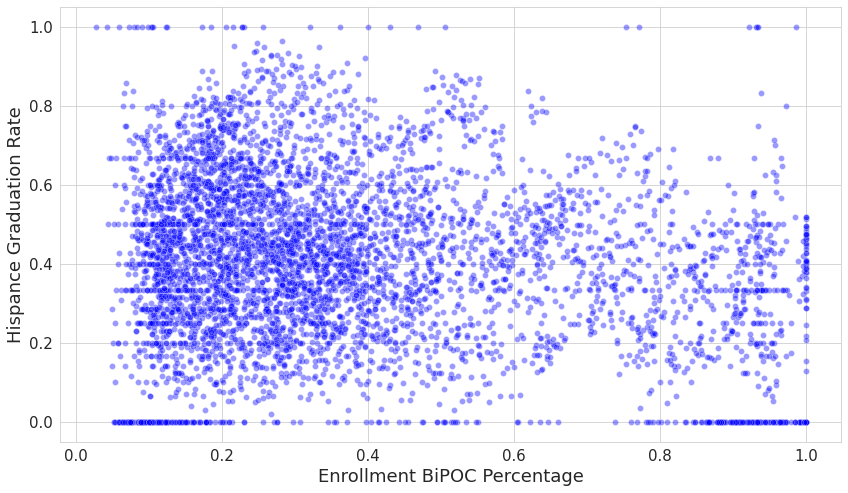

In [52]:
graphPlots('e_BiPOC_pct', 'gr_Hispanic_pct', "Enrollment BiPOC Percentage", "Hispance Graduation Rate")

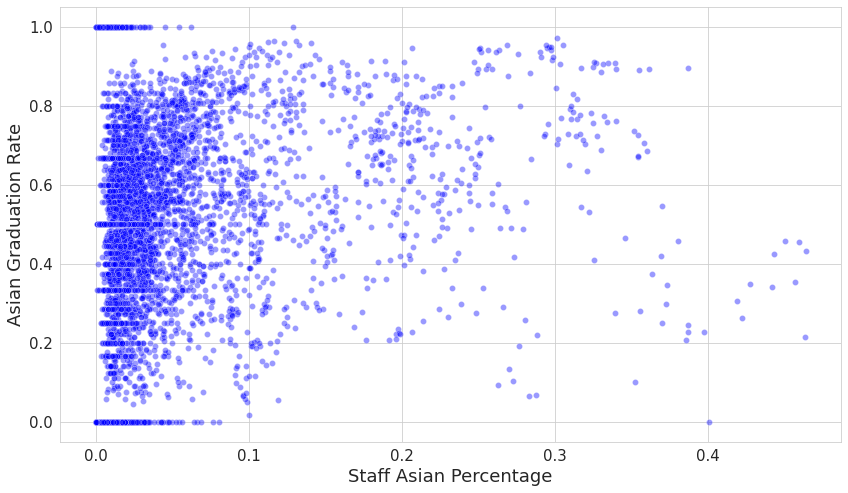

In [53]:
graphPlots('e_Asian_pct', 'gr_Asian_pct', "Staff Asian Percentage", "Asian Graduation Rate")

## BiPOC Graduation Rate Modeling

In [54]:
df_clean = df.dropna()
X = df_clean[['e_BiPOC_pct', 'co_BiPOC_pct', 'hr_BiPOC_pct', 'public_endowment', 'income_range', 'number_in_income_level1_pct', 'number_in_income_level2_pct', 'number_in_income_level3_pct', 'number_in_income_level4_pct', 'number_in_income_level5_pct']]
y = df_clean['gr_BiPOC_pct']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 1)

In [56]:
df_pred = pd.concat([X_test, y_test], axis = 1)

df_pred.head()

e_BiPOC_pct  co_BiPOC_pct  hr_BiPOC_pct  public_endowment  income_range  \
3312     0.119478      0.102093      0.119380        61090095.0      0.146624   
1932     0.114085      0.085539      0.105556       404522000.0      0.086842   
3534     0.631058      0.715385      0.253776        44728060.0      0.313725   
4376     0.675980      0.725502      0.295154       182002529.0      0.281174   
211      0.084501      0.072222      0.044313        31634000.0      0.186851   

      number_in_income_level1_pct  number_in_income_level2_pct  \
3312                     0.294304                     0.204641   
1932                     0.160526                     0.163158   
3534                     0.412565                     0.223689   
4376                     0.383777                     0.214891   
211                      0.311419                     0.166090   

      number_in_income_level3_pct  number_in_income_level4_pct  \
3312                     0.166667                     0.186709   
1932                     0.184211                     0.247368   
3534                     0.161665                     0.103241   
4376                     0.167676                     0.102603   
211                      0.202422                     0.195502   

      number_in_income_level5_pct  gr_BiPOC_pct  
3312                     0.147679      0.375000  
1932                     0.244737      0.757848  
3534                     0.098840      0.508649  
4376                     0.131053      0.567941  
211                      0.124567      0.276923

## Linear Regression

In [57]:
model = sm.OLS(y_train, sm.add_constant(X_train)).fit() 

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


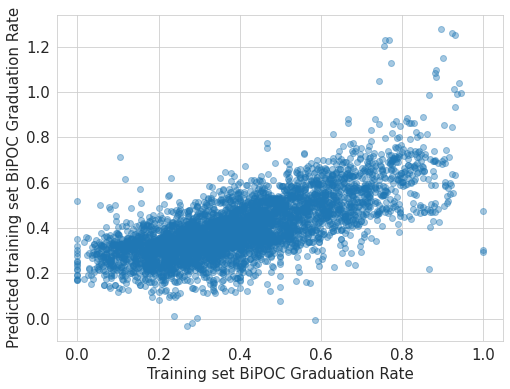

In [58]:
plt.figure(figsize = (8,6))

plt.plot(y_train, model.predict(sm.add_constant(X_train)), 'o', alpha = 0.4)

plt.xlabel('Training set BiPOC Graduation Rate', fontsize = 15)
plt.ylabel('Predicted training set BiPOC Graduation Rate', fontsize = 15)

plt.tick_params(labelsize = 15);

In [59]:
y_pred_lr = model.predict(sm.add_constant(X_test))

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


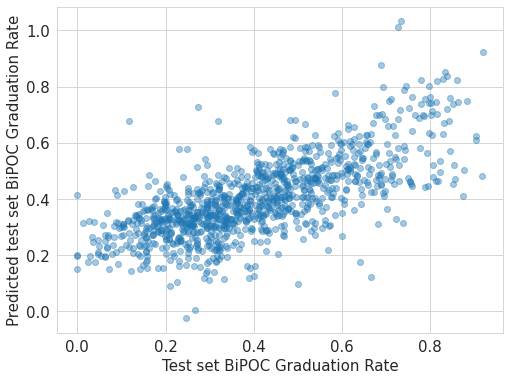

In [60]:
plt.figure(figsize = (8,6))

plt.plot(y_test, y_pred_lr, 'o', alpha = 0.4);

plt.xlabel('Test set BiPOC Graduation Rate', fontsize = 15)
plt.ylabel('Predicted test set BiPOC Graduation Rate', fontsize = 15)

plt.tick_params(labelsize = 15)

In [61]:
# Mean Squared Error
mean_squared_error(y_test, y_pred_lr, squared = False).round(3)

0.136

In [62]:
# Mean Absolute Error
mean_absolute_error(y_test, y_pred_lr).round(3)

0.106

In [63]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           gr_BiPOC_pct   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     500.2
Date:                Thu, 08 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:28:50   Log-Likelihood:                 2501.8
No. Observations:                4348   AIC:                            -4984.
Df Residuals:                    4338   BIC:                            -4920.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

## Random Forest

In [64]:
model_rf = RandomForestRegressor(100, min_samples_leaf=5)

In [65]:
model_rf.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=5)

In [66]:
y_pred_rf = model_rf.predict(X_test)

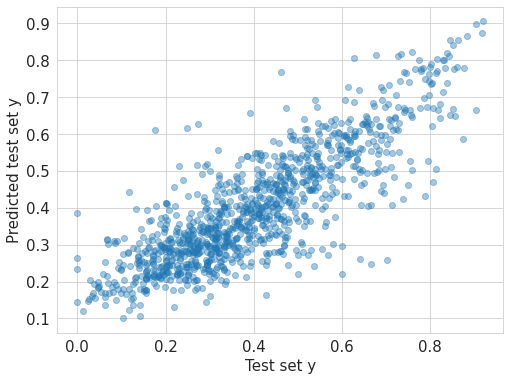

In [67]:
plt.figure(figsize = (8,6))

plt.plot(y_test, y_pred_rf, 'o', alpha = 0.4);

plt.xlabel('Test set y', fontsize = 15)
plt.ylabel('Predicted test set y', fontsize = 15)

plt.tick_params(labelsize = 15);

In [68]:
mean_squared_error(y_test, y_pred_rf, squared = False).round(3)

0.106

In [69]:
r_squared = model_rf.score(X, y)
print(r_squared)

0.8453072539054682


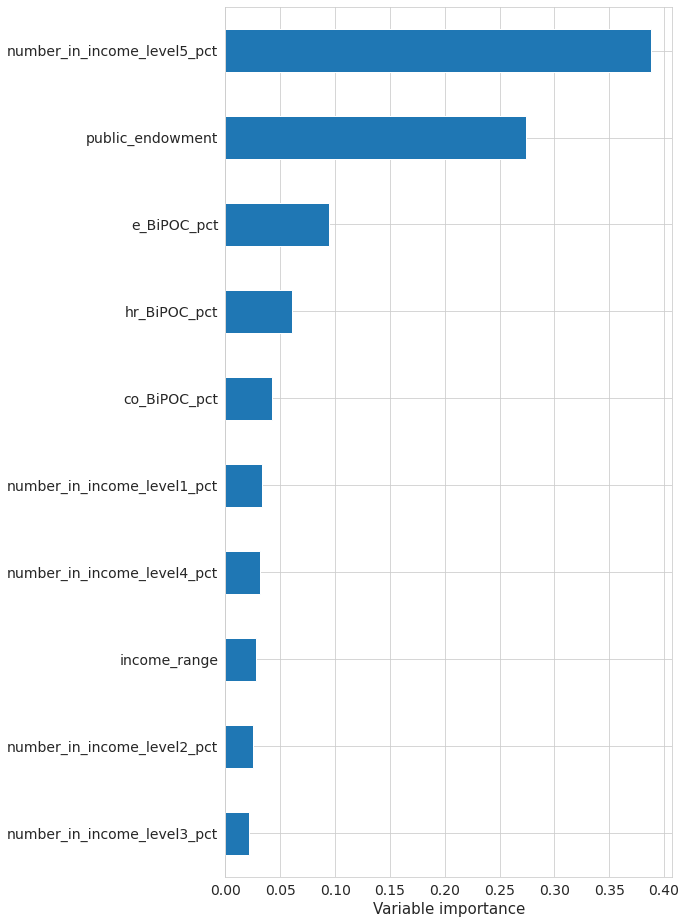

In [70]:
(pd.DataFrame(dict(cols=X_train.columns, imp=model_rf.feature_importances_)).
 sort_values(by = 'imp').
 plot('cols', 'imp', 'barh', legend = False, figsize = (8,16)))

plt.ylabel('')
plt.xlabel('Variable importance', fontsize = 15)

plt.tick_params(labelsize = 14);

## Scaling with Multiple Linear Regression

In [71]:
scaler = preprocessing.StandardScaler().fit(X_train)

In [72]:
print(scaler.mean_, scaler.scale_)

[3.71963743e-01 3.66693446e-01 2.20124886e-01 1.96134205e+08
 3.19777831e-01 3.82071666e-01 1.70278788e-01 1.60889642e-01
 1.35331879e-01 1.51428024e-01] [2.48734366e-01 2.69604086e-01 1.95807813e-01 7.88103779e+08
 2.02792426e-01 1.82582721e-01 4.81038302e-02 4.50921652e-02
 7.13453135e-02 1.14856451e-01]


In [73]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [74]:
print(np.mean(X_train, axis = 0))
print(np.std(X_train, axis = 0))

print(np.mean(X_test, axis = 0))
print(np.std(X_test, axis = 0))

[-2.14077963e-16  8.33433292e-17 -7.02698658e-17  1.96101951e-17
 -1.78125939e-16  2.25517244e-16  1.98553225e-16  8.66116950e-17
  1.04587707e-16  1.67503750e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ 0.00396154  0.00999622 -0.00425374 -0.02759845  0.04640434  0.0465363
 -0.06652243 -0.0567878  -0.02764644 -0.0066484 ]
[1.01011325 1.01129496 1.00397699 0.83021022 1.05692568 1.05699102
 1.01938031 1.10920263 1.01177604 1.00983193]


In [75]:
model_scale = sm.OLS(y_train, sm.add_constant(X_train)).fit() 

In [76]:
print(model_scale.summary())

                            OLS Regression Results                            
Dep. Variable:           gr_BiPOC_pct   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     500.2
Date:                Thu, 08 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:28:54   Log-Likelihood:                 2501.8
No. Observations:                4348   AIC:                            -4984.
Df Residuals:                    4338   BIC:                            -4920.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4023      0.002    194.690      0.0

In [77]:
pd.DataFrame({'predictors': X.columns, 
              'coeffcients': model.params[1:].round(2), 
              'p-values':model.pvalues[1:].round(3)})

predictors  coeffcients  \
e_BiPOC_pct                                  e_BiPOC_pct         0.33   
co_BiPOC_pct                                co_BiPOC_pct        -0.10   
hr_BiPOC_pct                                hr_BiPOC_pct        -0.03   
public_endowment                        public_endowment         0.00   
income_range                                income_range        -0.17   
number_in_income_level1_pct  number_in_income_level1_pct        -0.10   
number_in_income_level2_pct  number_in_income_level2_pct         0.08   
number_in_income_level3_pct  number_in_income_level3_pct        -0.06   
number_in_income_level4_pct  number_in_income_level4_pct        -0.77   
number_in_income_level5_pct  number_in_income_level5_pct         1.18   

                             p-values  
e_BiPOC_pct                     0.000  
co_BiPOC_pct                    0.001  
hr_BiPOC_pct                    0.252  
public_endowment                0.000  
income_range                    0.000  
number_in_income_level1_pct     0.001  
number_in_income_level2_pct     0.110  
number_in_income_level3_pct     0.346  
number_in_income_level4_pct     0.000  
number_in_income_level5_pct     0.000

## Total Graduation Rate Modeling

In [78]:
df_clean = df.dropna()
X = df_clean[['e_BiPOC_pct', 'co_BiPOC_pct', 'hr_BiPOC_pct', 'public_endowment', 'income_range', 'number_in_income_level1_pct', 'number_in_income_level2_pct', 'number_in_income_level3_pct', 'number_in_income_level4_pct', 'number_in_income_level5_pct']]
y = df_clean['gr_total_pct']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 1)

In [80]:
df_pred = pd.concat([X_test, y_test], axis = 1)

df_pred.head()

e_BiPOC_pct  co_BiPOC_pct  hr_BiPOC_pct  public_endowment  income_range  \
3312     0.119478      0.102093      0.119380        61090095.0      0.146624   
1932     0.114085      0.085539      0.105556       404522000.0      0.086842   
3534     0.631058      0.715385      0.253776        44728060.0      0.313725   
4376     0.675980      0.725502      0.295154       182002529.0      0.281174   
211      0.084501      0.072222      0.044313        31634000.0      0.186851   

      number_in_income_level1_pct  number_in_income_level2_pct  \
3312                     0.294304                     0.204641   
1932                     0.160526                     0.163158   
3534                     0.412565                     0.223689   
4376                     0.383777                     0.214891   
211                      0.311419                     0.166090   

      number_in_income_level3_pct  number_in_income_level4_pct  \
3312                     0.166667                     0.186709   
1932                     0.184211                     0.247368   
3534                     0.161665                     0.103241   
4376                     0.167676                     0.102603   
211                      0.202422                     0.195502   

      number_in_income_level5_pct  gr_total_pct  
3312                     0.147679      0.494130  
1932                     0.244737      0.767932  
3534                     0.098840      0.511371  
4376                     0.131053      0.546930  
211                      0.124567      0.335556

## Linear Regression

In [81]:
model = sm.OLS(y_train, sm.add_constant(X_train)).fit() 

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


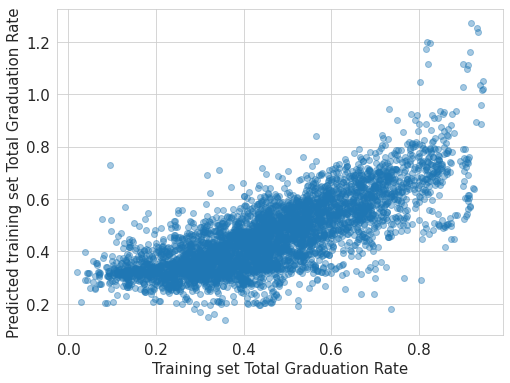

In [82]:
plt.figure(figsize = (8,6))

plt.plot(y_train, model.predict(sm.add_constant(X_train)), 'o', alpha = 0.4)

plt.xlabel('Training set Total Graduation Rate', fontsize = 15)
plt.ylabel('Predicted training set Total Graduation Rate', fontsize = 15)

plt.tick_params(labelsize = 15);

In [83]:
y_pred_lr = model.predict(sm.add_constant(X_test))

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


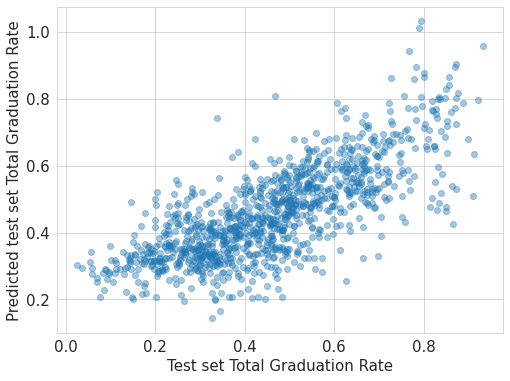

In [84]:
plt.figure(figsize = (8,6))

plt.plot(y_test, y_pred_lr, 'o', alpha = 0.4);

plt.xlabel('Test set Total Graduation Rate', fontsize = 15)
plt.ylabel('Predicted test set Total Graduation Rate', fontsize = 15)

plt.tick_params(labelsize = 15)

In [85]:
# Root Mean Squared Error
mean_squared_error(y_test, y_pred_lr, squared = False).round(3)

0.121

In [86]:
# Mean Absolute Error
mean_absolute_error(y_test, y_pred_lr).round(3)

0.094

In [87]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           gr_total_pct   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     660.3
Date:                Thu, 08 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:28:55   Log-Likelihood:                 3038.7
No. Observations:                4348   AIC:                            -6057.
Df Residuals:                    4338   BIC:                            -5994.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

## Random Forest

In [88]:
model_rf_total = RandomForestRegressor(100, min_samples_leaf=5)

In [89]:
model_rf_total.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=5)

In [90]:
y_pred_rf_total = model_rf_total.predict(X_test)

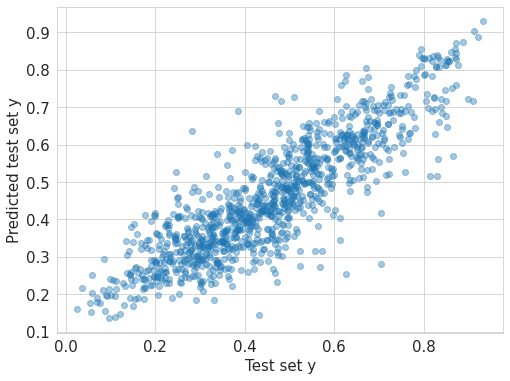

In [91]:
plt.figure(figsize = (8,6))

plt.plot(y_test, y_pred_rf_total, 'o', alpha = 0.4);

plt.xlabel('Test set y', fontsize = 15)
plt.ylabel('Predicted test set y', fontsize = 15)

plt.tick_params(labelsize = 15);

In [92]:
mean_squared_error(y_test, y_pred_rf_total, squared = False).round(3)

0.091

In [93]:
r_squared = model_rf_total.score(X, y)
print(r_squared)

0.8789395318705028


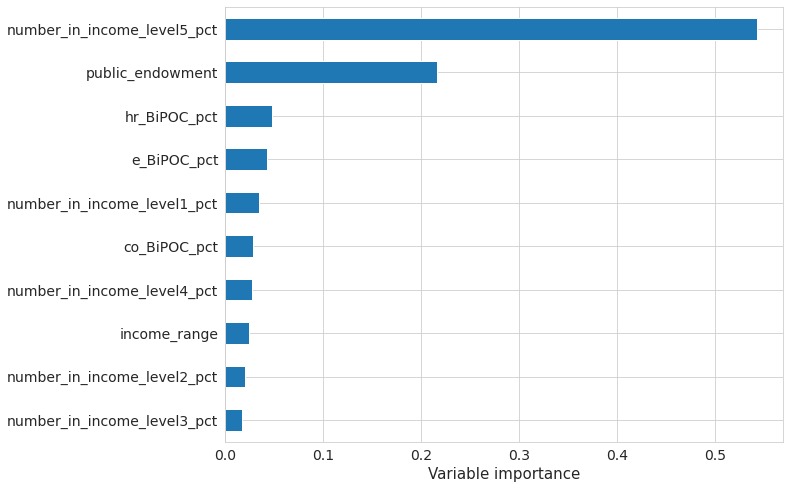

In [94]:
(pd.DataFrame(dict(cols=X_train.columns, imp=model_rf_total.feature_importances_)).
 sort_values(by = 'imp').
 plot('cols', 'imp', 'barh', legend = False, figsize = (10,8)))

plt.ylabel('')
plt.xlabel('Variable importance', fontsize = 15)

plt.tick_params(labelsize = 14);